![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+GenAI&dt=Vertex+AI+GenAI+For+Document+Q%26A+-+MLB+Rules.ipynb)

# UmpireBot - MLB Rules Q&A

**What?**

Ask questions of the rules for MLB and get answers with specific references to official rules.

**Sources:**

The official MLB rules are at [this link](https://www.mlb.com/official-information).  This is a 192 page PDF document.

**Tools:**
- Vertex AI LLM Embedding API
  - `vertexai.preview.language_models.TextEmbeddingModel.from_pretrained('embedding-gecko@001')`
- Vertex AI GenAI Language Model API
  - `vertexai.preview.language_models.TextGenerationModel.from_pretrained('text@bison-001')`
- Input file processing into documents/elements with GCP Document AI
  - `google.cloud.documentai.DocumentProcessorServiceClient()`
- Embedding search: with [ScaNN](https://github.com/google-research/google-research/tree/master/scann), [chromadb](https://github.com/chroma-core/chroma), [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview)
  - this example uses `ScaNN` in the notebook

---

**Google Cloud Vertex AI Generative AI Support**

Vertex AI Generative AI gives access to Google's large genearative AI models and also enables you to test, tune, and deploy them for your applications. Get an overview [here](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview).

---

**How:**

- Create documents from the source information.
  - <u>Definition</u>: a document is a section of the rules
- Create embeddings for each document
- Ask a question
  - Create an embedding of the question
  - Use vector similarity to retrieve embeddings for related documents
  - Retrieve the documents associated with returned embeddings
  - Prepare a prompt to answer the question using the documents as context
- Present the response as an answer with links to the related documents (sections of the document).

**What is Unique?**

An LLM is likely unexposed to a users private content.  This appoach constructs a summarization prompt for an LLM by first retriving context for the question from the users documents using embeddings.  This also allows the response to be accompanied by direct reference to the users documentation used in the prompt.

**Notes**

- An LLM is likely trained on many sources that probably include lots of general knowledge, even information like what is used here.  It is also likely knowledgable of past outdated information which can be a benefit - or detriment - to accuracy.  This approach directly uses the version of the document that currently applies.

**References**

- [Vertex AI GenAI Studio](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview)
    - Vertex AI [Python Client](https://cloud.google.com/python/docs/reference/aiplatform/latest)
- [Document AI](https://cloud.google.com/document-ai/docs/overview)
    - Document AI [Parsers](https://cloud.google.com/document-ai/docs/processors-list)
    - Document AI [Python Client](https://cloud.google.com/python/docs/reference/documentai/latest)

**Internal References**

This approach was adapted from the excellent [Intra-Knowledge Q&A](https://colab.sandbox.google.com/drive/1_rlAvsa1xAQaQZ281vkpq0CyIzVFQLXa#scrollTo=aImqcxUQqj2n) example created by OCTO

**TO DO**

- [X] Use The Document AI Document Processor
  - [X] rate limit calls to DocAI but also create async online calls
- [X] Use ScaNN to create a local index
- [X] Save the parsed elements and embeddings to GCS for faster repeat use of this notebook.
- [ ] Use Vertex AI Matching Engine
- [ ] add multistep context accumulation

---
## Overview

<p><center>
    <img alt="Overview Chart" src="../architectures/notebooks/applied/genai/doc_qa.png" width="55%">
</center><p>


---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Vertex%20AI%20GenAI%20For%20Document%20Q&A%20-%20MLB%20Rules.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs

In [ ]:
# Vertex AI GenAI Studio SDK - Update the aiplatform SDK
!pip install google.cloud.aiplatform -U -q --user

# for working with embeddings locally
!pip install scann -q --user

# For GCP DocAI and presentation of results
!pip install google-cloud-documentai -q --user
!pip install PyPDF2 -U -q --user
!pip install Pillow -U -q --user

In [47]:
# Enable Document AI For This Project
!gcloud services enable documentai.googleapis.com
# Enable Vertex AI FOr This Project
!gcloud services enable aiplatform.googleapis.com

The `aiplatform` version needs to be 1.25.0 or higher for the LLM functionality:

In [3]:
import google.cloud.aiplatform as aiplatform
aiplatform.__version__

'1.25.0'

**RESTART RUNTIME**

---
## Setup

Inputs

In [4]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [5]:
REGION = 'us-central1'
EXPERIMENT = 'mlb-rules'
SERIES = 'applied-genai'

# make this the gcs bucket for storing files
GCS_BUCKET = PROJECT_ID 

# make this the BQ Project / Dataset / Table prefix to store
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT

# location for the source document (PDF): can be http or gs://
source_document = 'https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf'
#source_document = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/wqn5ah4c3qtivwx3jatm.pdf'

# first question to ask
question = "What are the rules for baseball?"

Packages

In [6]:
import os
import io
import json
import base64
import requests
import concurrent.futures
import time

import PyPDF2
import IPython
import PIL
import PIL.ImageFont, PIL.Image, PIL.ImageDraw
import shapely

import scann
import numpy as np

import vertexai.preview.language_models
from google.cloud import aiplatform
from google.cloud import documentai
from google.cloud.documentai_v1 import Document
from google.cloud import storage
from google.cloud import bigquery

2023-05-13 15:54:24.322194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 15:54:27.654524: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-13 15:54:27.654686: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

Clients

In [7]:
vertexai.init(project = PROJECT_ID, location = REGION)
aiplatform.init(project = PROJECT_ID, location = REGION)
bq = bigquery.Client(project = PROJECT_ID)
LOCATION = REGION.split('-')[0]
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

---
## Vertex LLM Setup

- TextEmbeddingModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings)
    - TextEmbeddingModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.language_models.TextEmbeddingModel)
- TextGenerationModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/text/test-text-prompts)
    - TextGenerationModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.language_models.TextGenerationModel)

In [8]:
# create links to model: embedding api and text generation
embedding_model = vertexai.preview.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko@001')
textgen_model = vertexai.preview.language_models.TextGenerationModel.from_pretrained('text-bison@001')

Test embedding model:

In [9]:
embedding_model.get_embeddings([question])[0].values[0:10]

[0.044936999678611755,
 0.012650316581130028,
 0.01574002020061016,
 0.05652769282460213,
 0.012828737497329712,
 -0.03555307909846306,
 0.01662035472691059,
 0.029156366363167763,
 -0.031393833458423615,
 0.038452841341495514]

Test test generation (llm) model:

In [10]:
textgen_model.predict(question)

Baseball is a bat-and-ball game played between two teams of nine players on a field in the shape of a diamond. The game is played with a hard, round ball and a bat. The object of the game is for a team to score more runs than the opposing team.

A run is scored when a player advances around all four bases in the correct order. The bases are located at first, second, third, and home plate. A player can advance to the next base by hitting the ball and running to the next base before the ball is thrown to the fielder covering that base.

The game is

---
## Get/Create Document AI Processors

Using the [General Form Processor](https://cloud.google.com/document-ai/docs/processors-list#general_processors) and [Document Splitter](https://cloud.google.com/document-ai/docs/processors-list#processor_doc-splitter).



In [11]:
PARSER_DISPLAY_NAME = 'my_general_processor'
PARSER_TYPE = 'FORM_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-form-parser-v2.0-2022-11-10'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
  if p.display_name == PARSER_DISPLAY_NAME:
    parser = p
    print('Retrieved Existing Parser')
if 'parser' not in locals():
  parser = docai_client.create_processor(
      parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
      processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
  )
  print('Created New Parser')

parser

Retrieved Existing Parser


name: "projects/1026793852137/locations/us/processors/99dc9d70b803f826"
type_: "FORM_PARSER_PROCESSOR"
display_name: "my_general_processor"
state: ENABLED
process_endpoint: "https://us-documentai.googleapis.com/v1/projects/1026793852137/locations/us/processors/99dc9d70b803f826:process"
create_time {
  seconds: 1683799767
  nanos: 293339000
}
default_processor_version: "projects/1026793852137/locations/us/processors/99dc9d70b803f826/processorVersions/pretrained-form-parser-v1.0-2020-09-23"

---
## Get The Document

Get the source PDF from GCS or a URL and store as a list of pages: `pdfs`.

Get Location of File

In [12]:
if source_document.startswith('http'):
    document_location = 'URL'
    print('Use requests to get online document')
elif source_document.startswith('gs'):
    document_location = 'GCS'
    print('Use GCS to get document in GCS')
else:
    document_location = 'UNKNOWN'
    print(f'The source_document variable points to a document in an unknown location type (not gs:// or http): {source_document}')

Use requests to get online document


Copy the PDF to memory:

In [13]:
if document_location == 'URL':
    response = requests.get(source_document).content
elif document_location == 'GCS':
    blob = bucket.blob(source_document.split(f'gs://{GCS_BUCKET}/')[1])
    response = blob.download_as_bytes()

In [14]:
type(response)

bytes

Split the PDF into a document per page:

In [15]:
pdf = PyPDF2.PdfReader(io.BytesIO(response))

In [16]:
len(pdf.pages)

192

In [17]:
pdfs = []
for page_num, page in enumerate(pdf.pages, 1):
  writer = PyPDF2.PdfWriter()
  writer.add_page(page)
  with io.BytesIO() as bytes_stream:
    pdfs.append(writer.write(bytes_stream)[1].getbuffer().tobytes())

---
## Files From Previous Run on GCS
If available

In [18]:
if len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/results.json'))) > 0:
    print('Copying previous run to local...')
    
    # load results: the raw data from docai parsing
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/results.json')
    results = [json.loads(line) for line in blob.download_as_text().splitlines()]
    
    # load documents: the prepared results from the docai parsing results
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/documents.json')
    documents = [json.loads(line) for line in blob.download_as_text().splitlines()]
    
    # load page images for presentation: stored in the results
    page_images = []
    for r, result in enumerate(results):
        document_image = PIL.Image.open(
            io.BytesIO(
                # stored as string, use .encode() to convert to bytes, use base64.decodebytes to decode
                base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
        page_images.append(document_image)    
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
else:
    print('No previous run available to copy over')
    PRIOR_PARSE = False

Copying previous run to local...


---
## Parse Documents

Results of:
- [google.cloud.documentai.DocumentProcessorServiceClient().process_document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.services.document_processor_service.DocumentProcessorServiceClient#google_cloud_documentai_v1_services_document_processor_service_DocumentProcessorServiceClient_process_document)
  - are in the format of
    - [google.cloud.documentai_v1.types.ProcessResponse()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessResponse)
      - which contains `.document` in the format of:
        - [google.cloud.documentai_v1.types.Document](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)

Converting the Document to:
- JSON with .to_json()
- dictionary with .to_dict()

**Document AI Notes:**
- In this application we are using online processing.  This has a limit of 15 pages per document.  Switch to batch increases this to 100 pages for the Form Parser (General).
- Online processing has a default qouta of 120 request per minute per project. The code below implement waiting time to avoid this limit.
- [Reference](https://cloud.google.com/document-ai/quotas)

In [19]:
rate_limit_minute = 120
adjust_rate_limit = rate_limit_minute / 2

In [20]:
def docai_runner(p, start, raw_document):
  sleep_time = (p * (60/adjust_rate_limit)) - (time.time() - start)
  if sleep_time > 0: time.sleep(sleep_time)

  return (p, docai_client.process_document(request = dict(raw_document = raw_document, name = parser.name)))

In [21]:
if PRIOR_PARSE:
  print('Using Prior Results')
else:
  print('No Prior Results, Parsing with Document AI')
  print(f"The Expected runtime for the parsing is {(len(pdfs)/adjust_rate_limit):.2f} minutes")
  results = [None] * len(pdfs)
  start = time.time()
  with concurrent.futures.ThreadPoolExecutor(max_workers = len(pdfs)) as executor:
    futures = [
        executor.submit(
            docai_runner,
            p, start,
            documentai.RawDocument(content = pdf, mime_type = 'application/pdf')
        ) for p, pdf in enumerate(pdfs)
    ]
    for future in concurrent.futures.as_completed(futures):
      #result = futures[future]
      results[future.result()[0]] = (Document.to_dict(future.result()[1].document))

Using Prior Results


In [22]:
len(pdfs), len(results)

(192, 192)

In [23]:
if PRIOR_PARSE:
  print('Using Prior Documents Preparation')
else:
  documents = []
  page_images = []
  for r, result in enumerate(results):
    document_image = PIL.Image.open(
        io.BytesIO(
            base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
    page_images.append(document_image)

    tables = []
    for t, table in enumerate(result['pages'][0]['tables']):
      table_txt = ''
      if 'text_anchor' in table['layout'].keys():
        for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
          if t == 0 and s == 0: start = 0
          else: start = int(segment['start_index'])
          end = int(segment['end_index'])
          table_txt += result['text'][start:end+t]

      vertices = []
      for vertex in table['layout']['bounding_poly']['normalized_vertices']:
        vertices.append(dict(x = vertex['x'] * document_image.size[0], y = vertex['y'] * document_image.size[1]))
      tables.append(shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices]))

      documents.append(
          dict(
              page_content = table_txt,
              metadata = dict(
                  page = r+1,
                  table = t+1,
                  row = len(documents),
                  filename = source_document.split('/')[-1]
              ),
              extras = dict(
                  #image = base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8')),
                  vertices = vertices
              )
          )
      )

    for p, paragraph in enumerate(result['pages'][0]['paragraphs']):

      paragraph_txt = ''
      for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
        if p == 0 and s == 0: start = 0
        else: start = int(segment['start_index'])
        end = int(segment['end_index'])
        paragraph_txt += result['text'][start:end+1]

      vertices = []
      for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
        vertices.append(dict(x = vertex['x'] * document_image.size[0], y = vertex['y'] * document_image.size[1]))

      use_paragraph = True
      for t_shape in tables:
        p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
        if p_shape.intersects(t_shape): use_paragraph = False

      if use_paragraph:
        documents.append(
            dict(
                page_content = paragraph_txt,
                metadata = dict(
                    page = r+1,
                    paragraph = p+1,
                    row = len(documents),
                    filename = source_document.split('/')[-1]
                ),
                extras = dict(
                    #image = base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8')),
                    vertices = vertices
                )
            )
        )

len(documents)

Using Prior Documents Preparation


1431

In [24]:
print(documents[300]['page_content'])

(H) One base, if a ball, pitched to the batter, or thrown by the
pitcher from his position on the pitcher's plate to a base
to catch a runner, goes into a stand or a bench, or over or
through a field fence or backstop. The ball is dead;
3


In [25]:
print(documents[300]['metadata'])

{'page': 43, 'paragraph': 6, 'row': 300, 'filename': 'wqn5ah4c3qtivwx3jatm.pdf'}


---
## Get Embeddings


In [26]:
rate_limit_minute = 150

In [27]:
if PRIOR_PARSE:
  print('Embeddings created on previous run.')
else:
  print(f"The expected run time for embeddings is {(len(documents)/rate_limit_minute):.2f} minutes")
  start = time.time()
  for d, document in enumerate(documents):
    if d % rate_limit_minute == 0:
      time.sleep(((time.time() - start) % 60) + 10)
      start = time.time()
    text = document['page_content']
    if text:
      embed = embedding_model.get_embeddings([text])[0].values
    else:
      embed = []
    documents[d]['embedding'] = embed

Embeddings created on previous run.


## Create Embeddings Database


Use [ScaNN](https://github.com/google-research/google-research/tree/master/scann) to build a local vector search capability.

In [28]:
index = np.empty((len(documents), len(documents[0]['embedding'])))
index.shape

(1431, 768)

In [29]:
for i in range(index.shape[0]):
  if documents[i]['embedding']:
    index[i] = documents[i]['embedding']
normalized_index = index / np.linalg.norm(index, axis=1)[:, np.newaxis]

In [30]:
# configure ScaNN as a tree - asymmetric hash hybrid with reordering
# anisotropic quantization as described in the paper; see README

# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
builder = scann.scann_ops_pybind.builder(
    normalized_index, # index
    10, # num_neighbors
    "dot_product" # distance_measure
    )

searcher = builder.tree(
    num_leaves=index.shape[0], #num_leaves
    num_leaves_to_search=index.shape[0], #num_leaves_to_search
    training_sample_size=index.shape[0]
    ).score_ah(
      2,
      anisotropic_quantization_threshold=0.2
      ).reorder(
          index.shape[0]
          ).build()

In [31]:
def search_index(query, k):
    query = embedding_model.get_embeddings([query])[0].values
    neighbors, distances = searcher.search(query, final_num_neighbors=k)
    return list(zip(neighbors, distances))

In [32]:
search_index(question, 4)

[(64, 0.75561744), (1226, 0.7369107), (1247, 0.73249567), (37, 0.7273327)]

---
## Save To GCS For Future Runs

It can take awhile to run the parsing job above so save results for future runs of this notebook.  Also, this prevents recurring cost of running the Document AI parsing of the documents.

In [33]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
else:
    print('Writing contents of results and documents to GCS for future use.')
    
    # save results: json lines
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/results.json')
    blob.upload_from_string('\n'.join([json.dumps(result) for result in results]), content_type = 'application/json')
    
    # save documents: json lines
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/documents.json')
    blob.upload_from_string('\n'.join([json.dumps(document) for document in documents]), content_type = 'application/json')

This run loaded results from a prior run.  Not overwriting.


---
## Q&A With DocumentBot

Make a function that receives the users questions and:
- finds and retrieves relative sections of the rules
- prepares a prompt for Vertex AI Generative AI that includes the question and the context = sections of document
- Retrieves the response (answer) from Vertex AI Generative AI
- Retrieves the closest match section of the rules to the response/answer.
- Checks to see if the section closest to the response/answer was included in the sections of the rules provided in the prompt.
- Prepares and presents all the information back to the user

In [34]:
def document_bot(question, print_results = True):

    # Get the score for the closest match
    score = search_index(question, k = 1)[0][1]
    # retrieve related documents - the nubmer is based on the distance score from the closest match
    relevant_documentation = search_index(question, k = 1 + 2*int(10*(1-score)))

    #context = "\n".join([f'Context {c}:\n' + doc.page_content for c, (doc, score) in enumerate(relevant_documentation)])
    context = "\n".join([f'Context {c+1}:\n' + documents[doc[0]]['page_content'] for c, doc in enumerate(relevant_documentation)])
    prompt = f"""
      Give a detailed answer to the question using information from the provided contexts.

      {context}

      Question:
      {question}

      Answer and Explanation:
    """

    #print(prompt)

    response = textgen_model.predict(prompt)

    likely_source = search_index(response, k=1)
    likely_document = documents[likely_source[0][0]]

    # is likely_source in relevant_documentation?
    if likely_document['page_content'] in [documents[doc[0]]['page_content'] for doc in relevant_documentation]:
      #print('likely is in relevant')
      likely = True
    else:
      #print('likely is not in relevant')
      #likely = False
      # get most relevant context instead:
      likely = True
      likely_source = relevant_documentation[0:1]
      likely_document = documents[relevant_documentation[0][0]]

    if print_results:
      display(IPython.display.Markdown("## Response"))
      display(IPython.display.Markdown("### Question"))
      display(IPython.display.Markdown(f'{question}'))
      display(IPython.display.Markdown("### Answer"))
      display(IPython.display.Markdown(f'{response}'))
      if likely:
        display(IPython.display.Markdown("### Why?"))
        display(IPython.display.Markdown(f"{likely_document['page_content']}"))
        display(IPython.display.Markdown(f"* page: {likely_document['metadata']['page']}, relevance to answer: {likely_source[0][1]:.2f}"))
        display(IPython.display.Markdown(f"* {source_document}#page={likely_document['metadata']['page']}"))
      display(IPython.display.Markdown("### Sources"))
      #display(IPython.display.Markdown("\n".join(f"* {source_document}#page={doc[0].metadata['page']}\n\t* Document: {doc[0].metadata['filename']}, page: {doc[0].metadata['page']}, relevance to question: {doc[1]:.2f}\n\t* {doc[0].page_content}" for doc in relevant_documentation)))
      display(IPython.display.Markdown("\n".join(f"* {source_document}#page={documents[doc[0]]['metadata']['page']}\n\t* Document: {documents[doc[0]]['metadata']['filename']}, page: {documents[doc[0]]['metadata']['page']}, relevance to question: {doc[1]:.2f}" for doc in relevant_documentation)))

    if likely:
      #font = PIL.ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 20)
      #document_image = PIL.Image.open(io.BytesIO(documents[likely_source[0][0].metadata['row']]['extras']['image']))
      document_image = page_images[likely_document['metadata']['page']-1]
      draw = PIL.ImageDraw.Draw(document_image)
      vertices = documents[likely_document['metadata']['row']]['extras']['vertices']
      draw.polygon([
        vertices[0]['x'], vertices[0]['y'],
        vertices[1]['x'], vertices[1]['y'],
        vertices[2]['x'], vertices[2]['y'],
        vertices[3]['x'], vertices[3]['y']
      ], outline = 'green')
      IPython.display.display(document_image.resize((800, 1000)))

    return

In [35]:
question

'What are the rules for baseball?'

## Response

### Question

What are the rules for baseball?

### Answer

The rules for baseball are defined in the 2023 Official Baseball Rules.
The rules are divided into 7 sections:
1. Objectives of the Game
2. The Playing Field
3. Equipment and Uniforms
4. Game Preliminaries
5. Playing the Game
6. Improper Play, Illegal Action, and Misconduct
7. Ending the Game
The rules define the game of baseball, including the objectives of the game, the playing field, the equipment and uniforms used, the game preliminaries, how the game is played, improper play, illegal action, and misconduct, and how the game

### Why?

Table of Contents
2023 Official Baseball Rules
1.00 OBJECTIVES OF THE GAME
1
2.00 THE PLAYING FIELD
2
2.01 Layout of the Field
2.02 Home Base
2.03 The Bases
3
3
4
2.04 The Pitcher's Plate
2.05 Benches
4
3.00 EQUIPMENT AND UNIFORMS
3.01 The Ball
5
3.02 The Bat
5
6
7
7
8
3.03 Player Uniforms
3.04 Catcher's Mitt
3.05 First Baseman's Glove
3.06 Fielding Gloves
3.07 Pitcher's Glove
3.08 Helmets
3.09 Undue Commercialization.
3.10 Equipment on the Field
9
9
10
10
4.00 GAME PRELIMINARIES
11
12
12
15
4.01 Umpire Duties
11
4.02 Field Manager
12
4.03 Exchange of Lineup Cards
12
4.04 Weather and Field Conditions
15
4.05 Special Ground Rules
15
4.06 No Fraternization
16
4.07 Security.
16
4.08 Doubleheaders
16


* page: 7, relevance to answer: 0.88

* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=7

### Sources

* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=13
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 13, relevance to question: 0.76
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=165
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 165, relevance to question: 0.74
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=167
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 167, relevance to question: 0.73
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=7
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 7, relevance to question: 0.73
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=9
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 9, relevance to question: 0.73

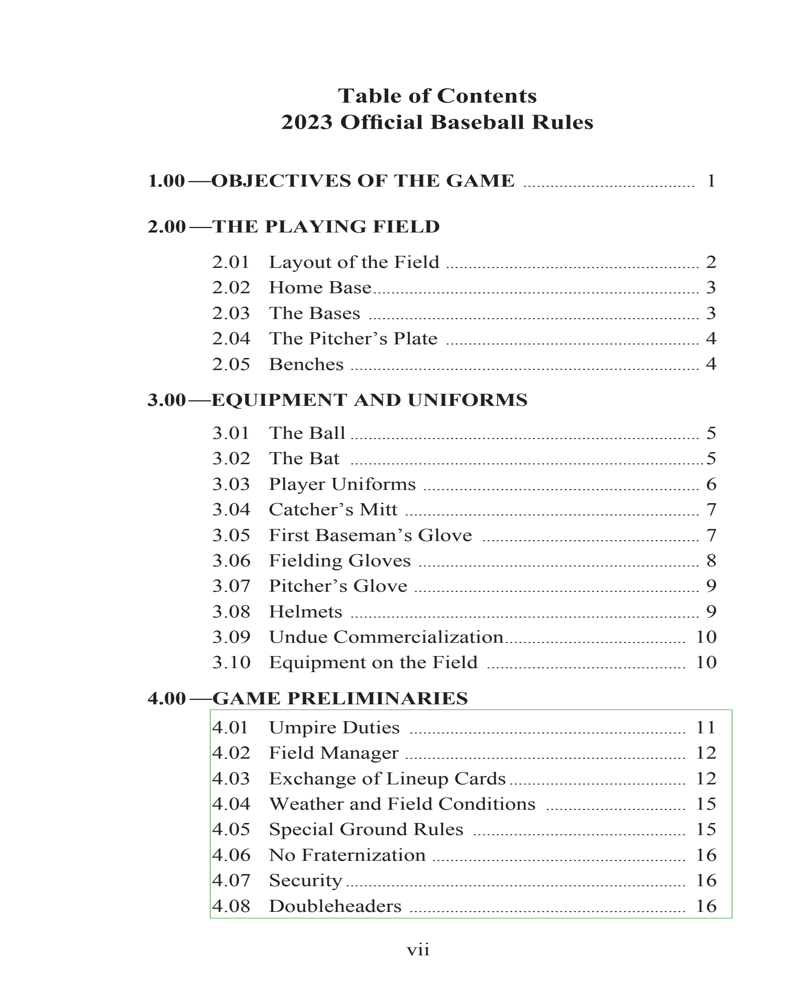

In [36]:
document_bot(question)

## Response

### Question

What is the definition of a balk?

### Answer

A balk is a rule in baseball that prevents a pitcher from deceiving the batter. A balk is called when the pitcher makes an illegal motion that could cause the batter to swing at the ball. The penalty for a balk is that the batter is awarded first base.

### Why?

(a) Balks
I

* page: 89, relevance to answer: 0.80

* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=89

### Sources

* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=89
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 89, relevance to question: 0.80
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=30
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 30, relevance to question: 0.78
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=89
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 89, relevance to question: 0.76
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=40
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 40, relevance to question: 0.67
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=50
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 50, relevance to question: 0.67

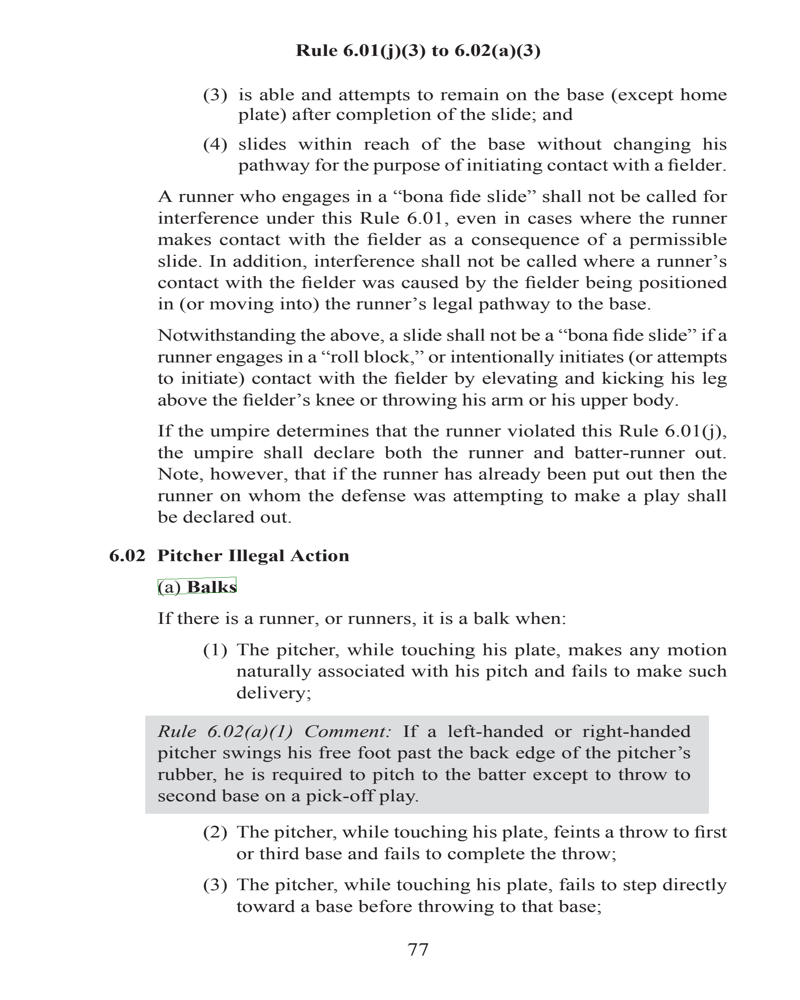

In [37]:
document_bot("What is the definition of a balk?")

## Response

### Question

Is a rule broken if three infielders are positioned on the same side of the field where the batter is more likely to hit the ball?

### Answer

Yes, a rule is broken if three infielders are positioned on the same side of the field where the batter is more likely to hit the ball.

The rule is 5.02(c) Comment, which states that "the purpose of the Infielder Positioning rule is to prevent the defense from having more than two infielders on either side of second base in an effort to anticipate where the batter will hit the ball prior to delivery of the pitch."

If, in the judgment of the umpire, any fielder attempts to circumvent the purposes of this Rule 5.02(c), the umpire shall

### Why?

Rule 5.02(c) Comment. Umpires should bear in mind that the
purpose of the Infielder Positioning rule is to prevent the defense
from having more than two infielders on either side of second
base in an effort to anticipate where the batter will hit the ball
prior to delivery of the pitch. If, in the judgment of the umpire,
any fielder attempts to circumvent the purposes of this Rule
5.02(c), the umpire shall assess the penalty described below.
P

* page: 31, relevance to answer: 0.88

* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=31

### Sources

* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=45
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 45, relevance to question: 0.79
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=31
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 31, relevance to question: 0.79
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=62
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 62, relevance to question: 0.79
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=124
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 124, relevance to question: 0.79
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=83
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 83, relevance to question: 0.79

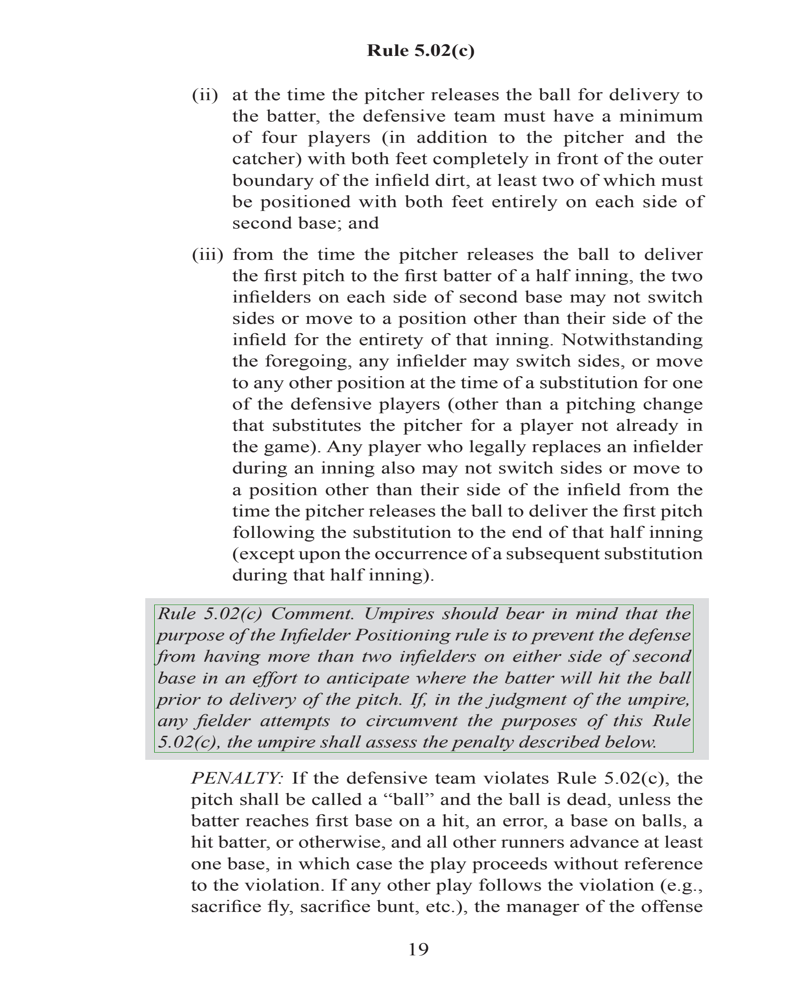

In [38]:
document_bot("Is a rule broken if three infielders are positioned on the same side of the field where the batter is more likely to hit the ball?")

## Response

### Question

A batter hits a ball that goes over the fence, but it is caught by a fan in the stands. Is the ball a home run?

### Answer

Yes, the ball is a home run.

The ball is a fair ball, and it goes over the fence. The ball is not deflected by the fielder. So the batter is entitled to a home run.

### Why?

(9) Any fair fly ball is deflected by the fielder into the stands,
or over the fence into foul territory, in which case the batter
shall be entitled to advance to second base; but if deflected
into the stands or over the fence in fair territory, the batter
shall be entitled to a home run. However, should such a
fair fly be deflected at a point less than 250 feet from home
plate, the batter shall be entitled to two bases only.
(b) The batter becomes a runner and is entitled to first base without
liability to be put out (provided he advances to and touches first
base) when:
(

* page: 37, relevance to answer: 0.83

* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=37

### Sources

* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=36
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 36, relevance to question: 0.76
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=43
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 43, relevance to question: 0.75
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=85
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 85, relevance to question: 0.75
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=37
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 37, relevance to question: 0.75
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=42
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 42, relevance to question: 0.74

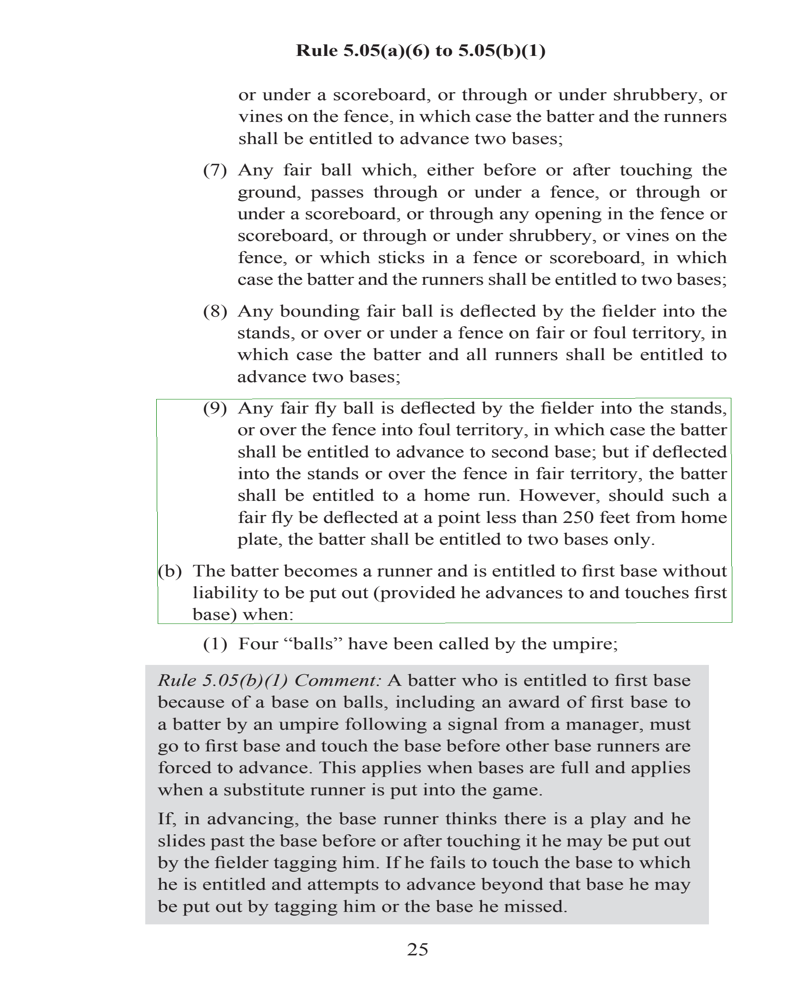

In [39]:
document_bot("A batter hits a ball that goes over the fence, but it is caught by a fan in the stands. Is the ball a home run?")

## Response

### Question

What is the official size of a base?

### Answer

The official size of a base is 18 inches square, not less than three nor more than five inches thick, and filled with soft material.

### Why?

First, second and third bases shall be marked by white canvas or
rubber-covered bags, securely attached to the ground as indicated in
Diagram 2. The first and third base bags shall be entirely within the
infield. The second base bag shall be centered on second base. The
bags shall be 18 inches square, not less than three nor more than five
inches thick, and filled with soft material.
2

* page: 16, relevance to answer: 0.76

* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=16

### Sources

* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=14
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 14, relevance to question: 0.73
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=16
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 16, relevance to question: 0.72
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=158
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 158, relevance to question: 0.72
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=143
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 143, relevance to question: 0.72
* https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=15
	* Document: wqn5ah4c3qtivwx3jatm.pdf, page: 15, relevance to question: 0.71

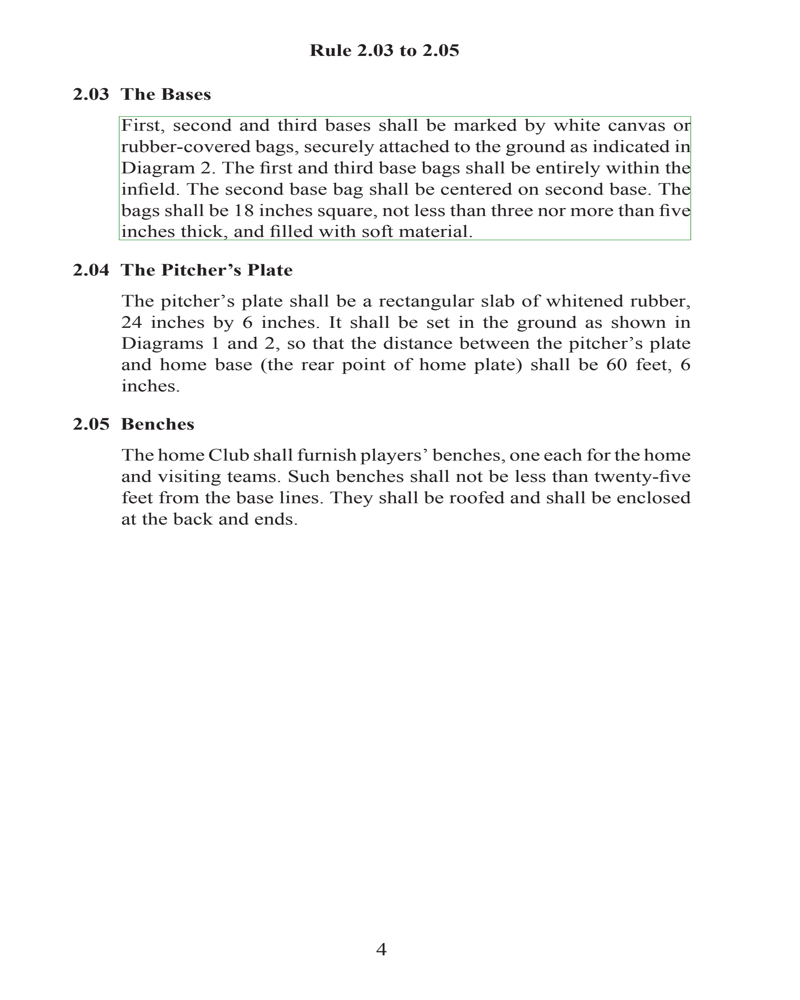

In [40]:
document_bot("What is the official size of a base?")